### 커스텀 데이터셋 검증용 코드

In [1]:
import torch
import coco_data
from yolo_dataset import CustomDataset

import cv2, random, os
from pycocotools.coco import COCO

In [2]:
# coco데이터셋의 메인 루트 디렉토리
root_dir = './../00_pytest_img/COCO dataset'
load_anno = 'val2017'
# 데이터셋 생성
exam_dataset = CustomDataset(root=root_dir, load_anno=load_anno)

# 커스텀 데이터셋과 동일한 coco 데이터셋 새로 생성하기
anno_path = os.path.join(root_dir, 'annotations')
json_file = 'instances_' + load_anno + '.json'

coco = COCO(os.path.join(anno_path, json_file))

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


In [3]:
print(f"이미지 개수 :{len(exam_dataset)}")
idx_list = range(len(exam_dataset))
chosen_idx = random.choice(idx_list)
print(f"선택한 이미지 ID : {chosen_idx}")

이미지 개수 :5000
선택한 이미지 ID : 1971


In [4]:
img, labels = exam_dataset[chosen_idx]
img_info = exam_dataset.get_img_info(chosen_idx)

for key, val in img_info.items():
    print(f"{key} : {val}")
print()
for i, label in enumerate(labels):
    print(f"{i}번째 label: {label.shape}")

license : 6
file_name : 000000007108.jpg
coco_url : http://images.cocodataset.org/val2017/000000007108.jpg
height : 426
width : 640
date_captured : 2013-11-18 07:51:11
flickr_url : http://farm6.staticflickr.com/5018/5550084353_1e556cbe11_z.jpg
id : 7108
obj_num : 5

0번째 label: torch.Size([52, 52, 85])
1번째 label: torch.Size([26, 26, 85])
2번째 label: torch.Size([13, 13, 85])


In [5]:
# 커스텀 데이터셋과 동일한 coco 데이터셋 에서 주석정보 추출
chosen_id = img_info['id']
ann_ids = coco.getAnnIds(imgIds=chosen_id)
anns = coco.loadAnns(ann_ids)

gt_boxes = []

for ann in anns:
    bbox = ann['bbox']
    # CP는 Class Probability이니 = Class ID
    CP_idx = coco_data.real_class_idx[ann['category_id']]

    x, y, w, h = bbox
    # bbox 좌표 정규화
    bx = (x + w / 2) / img_info['width']
    by = (y + h / 2) / img_info['height']
    bw = w / img_info['width']
    bh = h / img_info['height']

    gt_box = torch.tensor([bx, by, bw, bh, 1, CP_idx])
    gt_boxes.append(gt_box)

gt_boxes = sorted(gt_boxes, key=lambda box: (box[5], box[2] * box[3]))

# 정규 좌표평면상으로 변환한 GT_b_series_bbox 좌표 리스트 출력
for gt_box in gt_boxes:
    print(gt_box)

tensor([ 0.2535,  0.6631,  0.1293,  0.2980,  1.0000, 20.0000])
tensor([ 0.6582,  0.1109,  0.2597,  0.2175,  1.0000, 20.0000])
tensor([ 0.9414,  0.4961,  0.1089,  0.7585,  1.0000, 20.0000])
tensor([ 0.8080,  0.5909,  0.3622,  0.8181,  1.0000, 20.0000])
tensor([ 0.4250,  0.5248,  0.4572,  0.9257,  1.0000, 20.0000])


In [6]:
# 커스텀 데이터셋에서 1차 좌표변환 B_serise_bbox좌표정보 추출
first_label_boxes = []

for label in labels:
    S = label.size(0)
    # label = label.view(S, S, 3, -1)
    if label.size(2) != 85:
        raise ValueError(f"차원확인")

    bbox = label[..., :4]
    obj_s = label[..., 4]
    cla_s = label[..., 5:]
    cp_val, cp_id = torch.max(cla_s, dim=-1)

    coord_mask = obj_s > 0
    f_bbox = bbox[coord_mask]
    f_obj_s = obj_s[coord_mask]
    f_cp_id = cp_id[coord_mask]

    for i in range(f_bbox.size(0)):
        element = torch.cat([f_bbox[i], f_obj_s[i].unsqueeze(0), f_cp_id[i].unsqueeze(0)])
        first_label_boxes.append(element)

first_label_boxes = sorted(first_label_boxes, key=lambda box: (box[5], box[2] * box[3]))


# 정규 좌표평면상으로 변환한 Label_b_series_bbox 좌표 리스트 출력
for label_bbox in first_label_boxes:
    print(label_bbox)

tensor([ 0.2535,  0.6631,  0.1293,  0.2980,  1.0000, 20.0000])
tensor([ 0.2535,  0.6631,  0.1293,  0.2980,  1.0000, 20.0000])
tensor([ 0.2535,  0.6631,  0.1293,  0.2980,  1.0000, 20.0000])
tensor([ 0.6582,  0.1109,  0.2597,  0.2175,  1.0000, 20.0000])
tensor([ 0.6582,  0.1109,  0.2597,  0.2175,  1.0000, 20.0000])
tensor([ 0.6582,  0.1109,  0.2597,  0.2175,  1.0000, 20.0000])
tensor([ 0.9414,  0.4961,  0.1089,  0.7585,  1.0000, 20.0000])
tensor([ 0.9414,  0.4961,  0.1089,  0.7585,  1.0000, 20.0000])
tensor([ 0.9414,  0.4961,  0.1089,  0.7585,  1.0000, 20.0000])
tensor([ 0.8080,  0.5909,  0.3622,  0.8181,  1.0000, 20.0000])
tensor([ 0.8080,  0.5909,  0.3622,  0.8181,  1.0000, 20.0000])
tensor([ 0.8080,  0.5909,  0.3622,  0.8181,  1.0000, 20.0000])
tensor([ 0.4250,  0.5248,  0.4572,  0.9257,  1.0000, 20.0000])
tensor([ 0.4250,  0.5248,  0.4572,  0.9257,  1.0000, 20.0000])
tensor([ 0.4250,  0.5248,  0.4572,  0.9257,  1.0000, 20.0000])


In [7]:
# 커스텀 데이터셋에 tr을 적용하여 t_series bbox 좌표로 전환 수행
exam_dataset.anchor = coco_data.anchor_box_list

from torchvision.transforms import v2

transforamtion = v2.Compose([
    v2.Resize((416, 416)), #이미지 크기를 416, 416로
    v2.ToImage(),  # 이미지를 Tensor 자료형으로 변환
    v2.ToDtype(torch.float32, scale=True), #텐서 자료형을 [0~1]로 스케일링
    # v2.Normalize(mean=coco_val[0], std=coco_val[1]) #데이터셋 정규화
])

exam_dataset.transform = transforamtion

In [8]:
# t_series_bbox로 전환된 라벨 정보 추출
img, t_labels = exam_dataset[chosen_idx]
t_labels = [t_label.unsqueeze(0) for t_label in t_labels]
for t_label in t_labels:
    print(t_label.shape)

torch.Size([1, 52, 52, 255])
torch.Size([1, 26, 26, 255])
torch.Size([1, 13, 13, 255])


In [9]:
# 2차 좌표변환 t_series bbox 좌표 먼저 출력해보기
second_t_label_boxes = []

for label in t_labels:
    bs = label.size(0)
    S = label.size(1)

    t_label_view = label.view(bs, S, S, 3, -1)
    bbox = t_label_view[..., :4]
    obj_s = t_label_view[..., 4]
    cla_s = t_label_view[..., 5:]
    cp_val, cp_id = torch.max(cla_s, dim=-1)

    coord_mask = obj_s > 0
    f_bbox = bbox[coord_mask]
    f_obj_s = obj_s[coord_mask]
    f_cp_id = cp_id[coord_mask]

    for i in range(f_bbox.size(0)):
        element = torch.cat([f_bbox[i], f_obj_s[i].unsqueeze(0), f_cp_id[i].unsqueeze(0)])
        second_t_label_boxes.append(element)

second_t_label_boxes = sorted(second_t_label_boxes, key=lambda box: (box[5], box[2] * box[3]))


# 정규 좌표평면상으로 변환한 Label_t_series_bbox 좌표 리스트 출력
for label_t_bbox in second_t_label_boxes:
    print(label_t_bbox)


tensor([ 0.9519,  0.7974, -0.9701,  1.4909,  1.0000, 20.0000])
tensor([ 0.2380,  0.4493, -2.0400,  0.6638,  1.0000, 20.0000])
tensor([ 0.4760,  0.8987, -1.4346,  0.6248,  1.0000, 20.0000])
tensor([ 0.5034,  0.6821, -0.8385,  0.7396,  1.0000, 20.0000])
tensor([ 0.5251,  0.8221, -0.6054,  0.8630,  1.0000, 20.0000])
tensor([ 0.1828,  0.4805, -0.7987,  0.5568,  1.0000, 20.0000])
tensor([ 0.4760,  0.8987, -0.4268,  0.7072,  1.0000, 20.0000])
tensor([ 0.1123,  0.8829,  0.4420, -0.5419,  1.0000, 20.0000])
tensor([ 6.7816e-03,  3.6411e-01, -2.3303e-01,  7.0052e-01,  1.0000e+00,
         2.0000e+01])
tensor([ 0.4760,  0.8987, -0.7845,  0.1378,  1.0000, 20.0000])
tensor([ 0.1123,  0.8829,  0.0843, -1.1113,  1.0000, 20.0000])
tensor([ 0.5251,  0.8221, -0.6847,  0.0719,  1.0000, 20.0000])
tensor([ 0.2245,  0.7658, -0.1013,  0.2418,  1.0000, 20.0000])
tensor([ 0.5251,  0.8221, -0.1079,  0.1363,  1.0000, 20.0000])
tensor([ 5.0339e-01,  6.8205e-01, -3.4095e-01,  1.2816e-02,  1.0000e+00,
         2.00

In [10]:
from yolo_util import YoloComFunc
# YOLOv3Metrics의 convert_b_box 함수를 사용하기 위해 인스턴스화
util_func = YoloComFunc(anchor=coco_data.anchor_box_list)

In [11]:
# 2차 좌표변환 t_series bbox 좌표를 b_series_bbox로 convert_b_bbox 함수로 복원
second_label_bbox = []

for label in t_labels:
    bs = label.size(0)
    S = label.size(1)

    label = label.view(bs, S, S, 3, -1)

    label_boxes = label[..., :4]
    bbox = util_func.get_pred_bbox(label_boxes)
    obj_s = label[..., 4]
    cla_s = label[..., 5:]
    cp_val, cp_id = torch.max(cla_s, dim=-1)

    coord_mask = obj_s > 0
    f_bbox = bbox[coord_mask]
    f_obj_s = obj_s[coord_mask]
    f_cp_id = cp_id[coord_mask]

    for i in range(f_bbox.size(0)):
        element = torch.cat([f_bbox[i], f_obj_s[i].unsqueeze(0), f_cp_id[i].unsqueeze(0)])
        second_label_bbox.append(element)

second_label_bbox = sorted(second_label_bbox, key=lambda box: (box[5], box[2] * box[3]))

# 정규 좌표평면상으로 변환한 원복 Label_b_series_bbox 좌표 리스트 출력
for label_bbox in second_label_bbox:
    print(label_bbox)

tensor([ 0.2535,  0.6631,  0.1293,  0.2980,  1.0000, 20.0000])
tensor([ 0.2535,  0.6631,  0.1293,  0.2980,  1.0000, 20.0000])
tensor([ 0.2535,  0.6631,  0.1293,  0.2980,  1.0000, 20.0000])
tensor([ 0.2535,  0.6631,  0.1293,  0.2980,  1.0000, 20.0000])
tensor([ 0.2535,  0.6631,  0.1293,  0.2980,  1.0000, 20.0000])
tensor([ 0.2535,  0.6631,  0.1293,  0.2980,  1.0000, 20.0000])
tensor([ 0.2535,  0.6631,  0.1293,  0.2980,  1.0000, 20.0000])
tensor([ 0.2535,  0.6631,  0.1293,  0.2980,  1.0000, 20.0000])
tensor([ 0.2535,  0.6631,  0.1293,  0.2980,  1.0000, 20.0000])
tensor([ 0.6582,  0.1109,  0.2597,  0.2175,  1.0000, 20.0000])
tensor([ 0.6582,  0.1109,  0.2597,  0.2175,  1.0000, 20.0000])
tensor([ 0.6582,  0.1109,  0.2597,  0.2175,  1.0000, 20.0000])
tensor([ 0.6582,  0.1109,  0.2597,  0.2175,  1.0000, 20.0000])
tensor([ 0.6582,  0.1109,  0.2597,  0.2175,  1.0000, 20.0000])
tensor([ 0.6582,  0.1109,  0.2597,  0.2175,  1.0000, 20.0000])
tensor([ 0.6582,  0.1109,  0.2597,  0.2175,  1.0000, 20

In [12]:
import cv2, random, os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# 이미지 텐서를 다시 numpy 배열로 변환
image_np = img.squeeze(0).permute(1, 2, 0).numpy() * 255.0
image_np = image_np.astype(np.uint8)

# 원래 크기로 다시 크기 조정
original_height = img_info['height']
original_width = img_info['width']
image_restored = cv2.resize(image_np, (original_width, original_height))

In [13]:
# 결과 시각화 함수
def plot_boxes(image, boxes, labels):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    # 정규 좌표값 boxes를 원래 값으로 복원
    scale_y = image.shape[0] # height
    scale_x = image.shape[1] # width
    boxes = [[box[0] * scale_x, # x_center * width
              box[1] * scale_y, # y_center * height
              box[2] * scale_x, # w * width
              box[3] * scale_y, # h * height
              box[4], box[5]] for box in boxes]

    for box in boxes:
        x_center, y_center, w, h, conf, label = box
        # bbox를 그리는데 좌 상단 좌표, width, hight 필요
        x1 = x_center - w / 2
        y1 = y_center - h / 2

        # 라벨의 텍스트 좌표 및 bbox의 색깔 정하기
        label = int(label)
        superclass = coco_data.cls_map[label]
        color = coco_data.cls_color[superclass]

        rect = Rectangle((x1, y1), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        plt.text(x1, y1, s=labels[label], color='black', verticalalignment='top',
                 bbox={'color': color, 'pad': 0})

    plt.axis('off')
    plt.show()

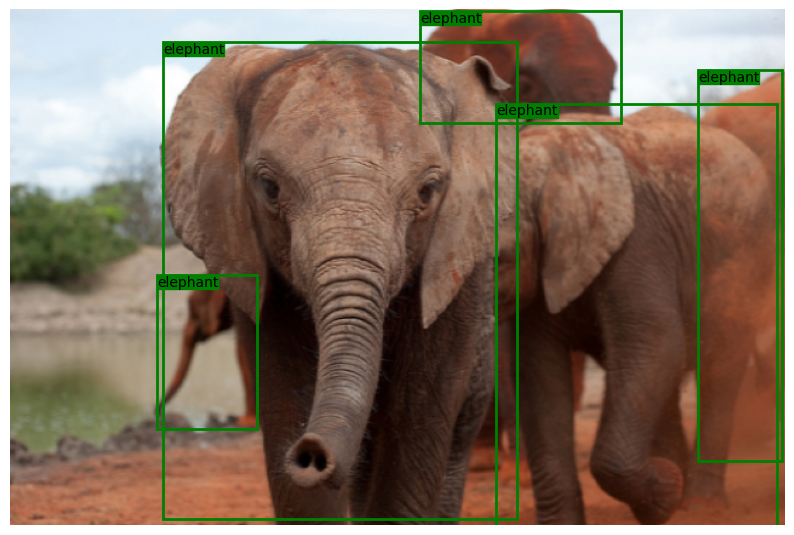

In [14]:
# Ground_Truth 좌표에 대한 결과 시각화
plot_boxes(image_restored, gt_boxes, coco_data.coco_label)

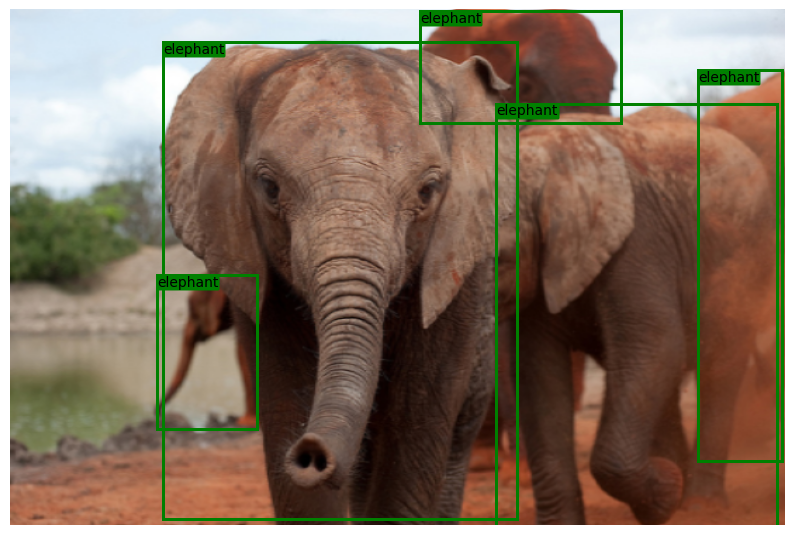

In [15]:
# 데이터셋의 b_bbox 시리즈 좌표로 데이터 출력
plot_boxes(image_restored, first_label_boxes, coco_data.coco_label)

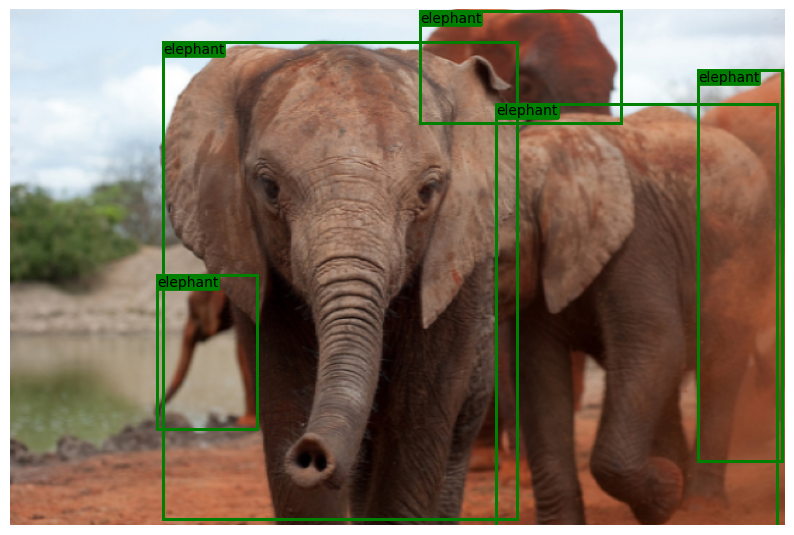

In [16]:
# 데이터셋의 '복 원 한' b_bbox 시리즈 좌표로 데이터 출력
plot_boxes(image_restored, second_label_bbox, coco_data.coco_label)